## PART 6a: Projector-Camera Correspondence

In [2]:
## Initialize everything

%run common.ipynb

import cv2 as cv
print("Imported opencv " + str(cv.__version__))
import PIL
print('Imported PIL' + str(PIL.__version__))

Importing libraries...
Done!
Initialize camera and default settings...
Done!
Define functions needed to capture images...
Done!
Generating patterns for projector...
Done!


Imported opencv 3.2.0
('Imported PIL', '4.0.0')


In [64]:
## Global variables

projector_brightness = 255

# projector images
grey = numpy.full((200,320), 127)
black = numpy.ones((200,320)) * 255
noise = numpy.random.rand(360,640) * 255;

In [55]:
# Button setup template
class basic_button(widgets.Button):
    output = widgets.Output()
    
    @output.capture()
    def on_button_clicked(b):
        clear_output()
        print("clicked at " + str(time.time()))

button1 = basic_button(description="button")
button1.on_click(basic_button.on_button_clicked)

display(button1)
display(basic_button.output)

basic_button(description=u'button', style=ButtonStyle())

Output()

In [4]:
## Functions for getting camera-projector correspondences

# Get correspondences for rows(pattern_x) and columns(pattern_y)
def get_correspondences():
    # Create a projection pattern
    pattern_x, pattern_y = numpy.meshgrid(numpy.arange(640),numpy.arange(360))
    pattern_x = numpy.uint16(pattern_x)
    pattern_y = numpy.uint16(pattern_y)
    
    x_corresp, x_mask, x_proj_img = corresp_helper(pattern_x)
    y_corresp, y_mask, y_proj_img = corresp_helper(pattern_y)
    
    return x_corresp, x_proj_img, y_corresp, y_proj_img

# Helper displays and captures graycode pattens for <pattern>
def corresp_helper(pattern):
    # Convert pattern to to gray codes (see gray code wikipedia page)
    # ptn ^ (ptn >> 1)
    pattern = numpy.bitwise_xor(pattern,numpy.right_shift(pattern,1))
    
    # Create empty arrays for correspondence map and projector codes
    img = numpy.uint16(numpy.zeros((200,320)))

    for itr in numpy.arange(10):
        # Extract one bit of gray code based on itr, shift back so it is in the 'ones' place
        ptn1 = numpy.right_shift(numpy.bitwise_and(pattern,2**itr),itr);
        ptn2 = 1-ptn1;

        # Display extracted pattern
        lightcrafter.set_pattern(projector_brightness * ptn1)
        time.sleep(1)
        img1 = numpy.uint16(256*get_raw_image())
        # Display complement
        lightcrafter.set_pattern(projector_brightness * ptn2)
        time.sleep(1)
        img2 = numpy.uint16(256*get_raw_image())

        # If img1 > img2 then bit was (probably) on
        # This means the captured value for pattern  pixel > complement pixel
        tmp = numpy.uint16(numpy.greater(img1,img2));
        tmp = numpy.left_shift(tmp,itr);
        # Concat into img
        img = numpy.bitwise_or(img, tmp)

    # Convert correspondence and projector codes to binary codes (see gray code wikipedia page)
    mask = numpy.right_shift(img,1)          # img stores captured gray codes
    proj_mask = numpy.right_shift(pattern,1) # pattern stores displayed gray codes
    for itr in numpy.arange(10):
        img = numpy.bitwise_xor(img, mask)
        mask = numpy.right_shift(mask,1)

        pattern = numpy.bitwise_xor(pattern, proj_mask)
        proj_mask = numpy.right_shift(proj_mask,1)
        
    lightcrafter.set_pattern(projector_brightness * numpy.ones((360,640)));
    time.sleep(1);
    mask = get_raw_image();
    
    return img, mask, pattern

In [70]:
## Load correspondneces from file or capture new ones

def load_from_file():
    # Load correspondence and projector code arrays from file
    # Store in global vars
    global x_proj_img, y_proj_img, x_corresp, y_corresp
    x_proj_img = numpy.load("correspondences/x_proj_img.npy")
    y_proj_img = numpy.load("correspondences/y_proj_img.npy")
    x_corresp = numpy.load("correspondences/x_corresp.npy")
    y_corresp = numpy.load("correspondences/y_corresp.npy")
    
class load_correspondences(widgets.Button):
    output = widgets.Output()
    
    @output.capture()
    def on_button_clicked(b):
        clear_output()
        load_from_file()
        
        # Show correspondences
        print("x_corresp")
        plt.imshow(x_corresp); plt.show()
        print("y_corresp")
        plt.imshow(y_corresp); plt.show()

class save_correspondences(widgets.Button):
    output = widgets.Output()
    
    @output.capture()
    def on_button_clicked(b):
        # Save correspondence and projector code arrays to file
        global x_proj_img, y_proj_img, x_corresp, y_corresp
        numpy.save("correspondences/x_proj_img", x_proj_img)
        numpy.save("correspondences/y_proj_img", y_proj_img)
        numpy.save("correspondences/x_corresp", x_corresp)
        numpy.save("correspondences/y_corresp", y_corresp)
        print("saved")
        
class new_correspondences(widgets.Button):
    output = widgets.Output()
        
    @output.capture()
    def on_button_clicked(b):
        clear_output();        
        print("capturing new...")
        
        # get new corresp
        global x_corresp, x_proj_img, y_corresp, y_proj_img
        x_corresp, x_proj_img, y_corresp, y_proj_img = get_correspondences()
        print("done")
        
        # show correspondences
        print("x_corresp")
        plt.imshow(x_corresp); plt.show()
        print("y_corresp")
        plt.imshow(y_corresp); plt.show()

        # offer choice to save
        global button4
        display(button4)
        display(save_correspondences.output)
        
print("Capture new correspondences or load from file")
button3 = new_correspondences(description="Capture new")
button3.on_click(new_correspondences.on_button_clicked)

button4 = save_correspondences(description="Save to file")
button4.on_click(save_correspondences.on_button_clicked)

button5 = load_correspondences(description="Load from file")
button5.on_click(load_correspondences.on_button_clicked)

display(button3)
display(new_correspondences.output)

display(button5)
display(load_correspondences.output)

# by default, load from file
load_from_file()

Capture new correspondences or load from file


new_correspondences(description=u'Capture new', style=ButtonStyle())

Output()

load_correspondences(description=u'Load from file', style=ButtonStyle())

Output()

In [10]:
## Tools : Some functions I wrote as tools (mostly for debugging)

# convert 200x320 (raw) camera image to 360x640 (no color) projector image
def cam2proj(cam_img):
    return [[cam_img[r/2][c/2] for c in range(640)] for r in range(360)]

# visualize camera row/col in projector image, based on correspondence
def visualize_cam2proj():
    cw = 320
    ch = 200
    pw = 640
    ph = 360
    A1 = numpy.zeros((ch, cw))
    A2 = numpy.zeros((ph, pw))

    # get a line in cam img
    for i in range(cw):
        A1[100][i] = 1
    print("cam pts")
    plt.imshow(A1);plt.show()

    # find line in proj img
    for i in range(cw):
        c = x_corresp[100][i]
        r = y_corresp[100][i] 
        A2[r][c] = 1
        A2[r+1][c] = 1
        A2[r][c+1] = 1
        A2[r+1][c+1] = 1
    print("proj pts")
    plt.imshow(A2);plt.show()
    
# compute b - a, for two images
def bit_diff(b, a):
    if (a.shape != b.shape):
        print(str(a.shape) + " doesn't match " + str(b.shape))
        return None
    return numpy.bitwise_and(b, numpy.invert(a))

In [71]:
## (1) Make transformation matrix from 4 points in camera image plane and corresponding points in projector image plane

# Get 4 corners of a rectangle in camera image and corresponding pixel indices in projector image
def get_4_points():
    # 4 points in cam img (rect), may need to adjust manually
    cam_pts = numpy.array([[100,120], [100,80], [200,120], [200,80]])

    # Get 4 correspondig points in proj img
    proj_pts = numpy.zeros((4,2))
    for i in range(4):
        x = cam_pts[i,0]
        y = cam_pts[i,1]
        proj_pts[i,0] = x_corresp[y][x]
        proj_pts[i,1] = y_corresp[y][x]
    proj_pts = proj_pts.astype(int)
    
    # uncomment below to display visualization of corresponding points
#     A1 = numpy.zeros((200,320))
#     A2 = numpy.zeros((200,320))
#     for i in range(4):
#         A1[cam_pts[i,1]][cam_pts[i,0]] = 1
#         A2[proj_pts[i,1]/2][proj_pts[i,0]/2] = 1
#     print("cam pts")
#     plt.imshow(A1);plt.show()
#     print("proj pts")
#     plt.imshow(A2);plt.show()
    
    return cam_pts, proj_pts

# Create transformation matrix from camera to projector (planes), using 4 corresponding points
# from meach image plane
def make_transform_matrix():
        # get 4 points in camera image and corresponding points in projector image
        cam_pts, proj_pts = get_4_points()

        # getPerspectiveTransform and findHomography require float32 
        cam_pts = cam_pts.astype(numpy.float32)
        proj_pts = proj_pts.astype(numpy.float32)

        # get transformation matrix (camera image plane -> projector image plane)
        # (note) cv.findHomography can be used as well
        M = cv.getPerspectiveTransform(cam_pts, proj_pts)    
        
        return M

# Gets different transformation matrix from camera to projector since
# encoding color info changes dimensions (1 raw image encodes 4 color channel images)
def make_transform_matrix_c():
        # Get 4 points in camera image and corresponding points in projector image
        cam_pts, proj_pts = get_4_points()

        # GetPerspectiveTransform and findHomography require float32 
        cam_pts = cam_pts.astype(numpy.float32)
        proj_pts = proj_pts.astype(numpy.float32)
        
        # Scale cam_pts down to match shape of color channel images
        cam_pts = cam_pts / 2

        # Get transformation matrix (camera image plane -> projector image plane)
        M = cv.getPerspectiveTransform(cam_pts, proj_pts)    
        
        return M
    
# Wrapper function for raw image transform
def transform_image(image, M):
    return cv.warpPerspective(image, M, (640,360))

# Wrapper function for color image transform
def transform_image_c(raw_image, M_c):
    red_image   = raw_image[1::2,1::2]
    green_image = (raw_image[1::2,0::2] + raw_image[0::2,1::2]) / 2.0
    blue_image  = raw_image[0::2,0::2]
    
    red_warped = transform_image(red_image,M_c)
    green_warped = transform_image(green_image,M_c)
    blue_warped = transform_image(blue_image,M_c)
        
    color_warped = numpy.dstack((red_warped, green_warped, blue_warped))

    return color_warped

# make transformation matrices
M = make_transform_matrix()
M_c = make_transform_matrix_c()
print("made color and raw transformation matrices")

made color and raw transformation matrices


In [72]:
# Project from raw image
def project_from_raw():
    M = make_transform_matrix() # M can be reused

    # get an image
    lightcrafter.set_pattern(50 * numpy.uint16(numpy.ones((360,640))))    
    raw_image = get_raw_image()

    # apply transformation
    warped = transform_image(raw_image, M)

    # project
    lightcrafter.set_pattern(warped);

    # debug
    print("raw"); plt.imshow(raw_image); plt.show()
    print("image transformed with matrix"); plt.imshow(warped); plt.show();
    print("results from camera"); raw2 = get_raw_image(); plt.imshow(raw2/2);plt.show() #scaling for less contrast
    
# Project from color image
def project_from_color():
    M_c = make_transform_matrix_c()

    # get an image
    lightcrafter.set_pattern(70 * numpy.uint16(numpy.ones((360,640))))   
    time.sleep(1)
    raw_image = get_raw_image()
    color_image = get_color_image() # for debug purposes

    # apply transformation (with color)
    color_warped = transform_image_c(raw_image*0.5, M_c) # scaled down to prevent overflow

    # project (with color)
    lightcrafter.set_pattern_c(color_warped);

    # debug
    print("color camera image"); plt.imshow(color_image); plt.show()
    print("image transformed with matrix"); plt.imshow(color_warped/255); plt.show();
    print("results"); plt.imshow(get_raw_image()/2);plt.show() #scaling for less contrast
    plt.imshow(get_color_image());plt.show() #scaling for less contrast
    
# From button setup template
class project_button(widgets.Button):
    output = widgets.Output()
    
    @output.capture()
    def on_project_raw(b):
        clear_output()
        project_from_raw()
        
    @output.capture()
    def on_project_color(b):
        clear_output()
        project_from_color()

print("Project camera image back onto scene:")
button_raw = project_button(description="Raw image")
button_raw.on_click(project_button.on_project_raw)

button_color = project_button(description="Color image")
button_color.on_click(project_button.on_project_color)

display(button_raw)
display(button_color)
display(project_button.output)

Project camera image back onto scene:


project_button(description=u'Raw image', style=ButtonStyle())

project_button(description=u'Color image', style=ButtonStyle())

Output()

round 0
im


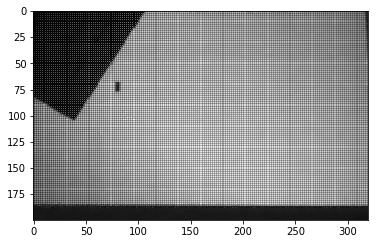

round 1
im


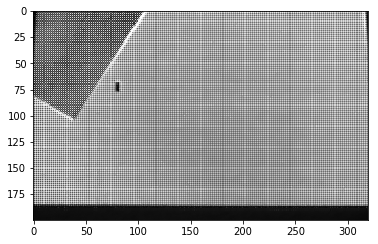

round 2
im


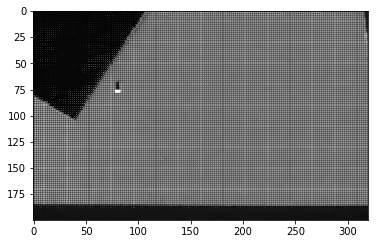

round 3
im


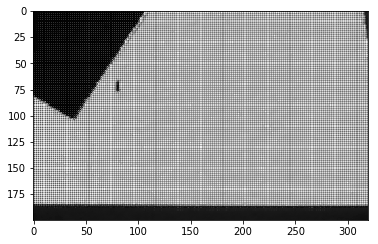

In [73]:
# (3.a) create grey image using pixel value difference between projector pattern and captured image
# attempted to use standard deviation as a metric for success, doesn't really work
lightcrafter.set_pattern(20 * numpy.uint16(numpy.ones((360,640))))    
im = get_raw_image()
patt = grey # guess
for i in range(4):
    print('round ' + str(i))
    
    # project guess
    warp = cv.warpPerspective(patt.astype(numpy.uint8), M, (640,360))
    lightcrafter.set_pattern(warp/2)
    time.sleep(1)
    
    # get image
    im = get_raw_image()
    # show img
    print('im'); plt.imshow(im); plt.show();
    
    # grey - im
    diff = numpy.add(grey, -1*im);
    
    # use diff to come up with new guess
    scale = 2 ** i
    patt = numpy.add(patt, diff/scale)

baseline black value=11.292765625
round 0: captured img


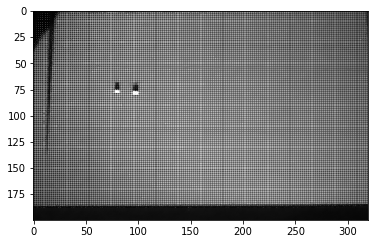

round 1: captured img


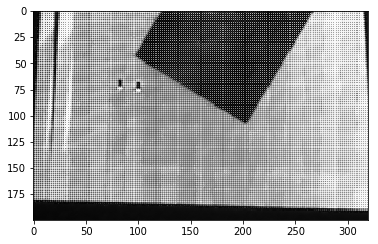

round 2: captured img


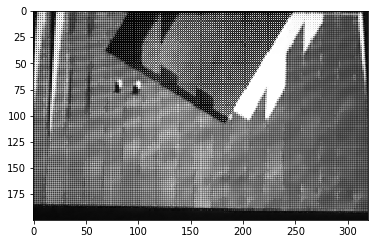

round 3: captured img


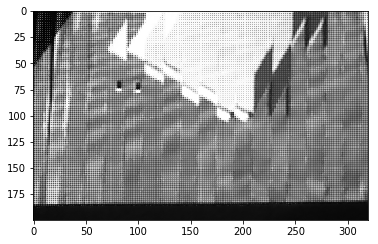

round 4: captured img


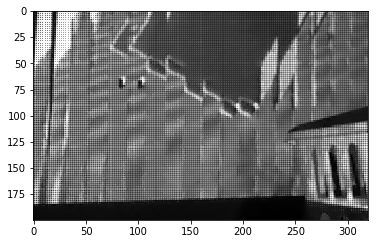

round 5: captured img


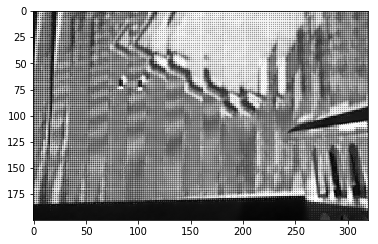

In [75]:
# (3.b) feedback illumination based on assumption that recorded pixel value b by camera is b=ax+c, 
# a is the reflectivity (modifies the response recorded by camera of a value from the projector)
# x is the value projected from the projector
# c is the illumination of the rest of the scene (a baseline to consider as black)
# Treat x as our guess to get b=target

target = 127 # might need to adjust based on baseline black

# get a baseline value for black
lightcrafter.set_pattern(numpy.zeros((360,640)))
time.sleep(1)
base_black = numpy.average(get_raw_image())
c = numpy.full((200,320), base_black)
print("baseline black value=" + str(base_black))

# start with grey projection as our 'guess'
x = grey/2

# do some number of iterations
for i in range(6):
    # cast x in case its type was changed
    x = x.astype(numpy.uint8)
    
    # project 
    lightcrafter.set_pattern(transform_image(x, M))
    time.sleep(1)
                             
    # image
    b = get_raw_image()
    print("round "+str(i)+": captured img");plt.imshow(b); plt.show()

    # reflectivity/modulation image, a=(b-c)/x
    a = numpy.divide(numpy.add(b, -1*c), numpy.clip(x,1,255))

    # want to find y s.t. target = ay + c, y=(target-c)/a
    y = numpy.divide(numpy.add(target, -1*c), numpy.clip(a,1,255))

    # update guess
    x = y

In [62]:
# Unsuccessful attempt to get corresponding pixel by matching correspondences for rows and columns (too slow)
# Provides intersting visualization though?
def show_corresondence_visualization():
    col_corresp_ind2 = numpy.array([x_corresp[i/320][i%320] for i in range(200*320)])
    row_corresp_ind2 = numpy.array([y_corresp[i/320][i%320] for i in range(200*320)])

    # find entry in corresp_ind that has value x
    def match2(val, corresp_ind):
        # create masks to extract pixels w values within 2 of v
        eq = numpy.full(200*320, val)
        lt1 = numpy.full(200*320, val-1)
        gt1 = numpy.full(200*320, val+1)
        lt2 = numpy.full(200*320, val-2)
        gt2 = numpy.full(200*320, val+2)
        masks = [eq, lt1, gt1, lt2, gt2]

        # extract and accumulate matching values
        m = numpy.full(200*320, 0)
        for ba in masks:
            ba = numpy.where(numpy.bitwise_xor(corresp_ind,ba) == 0, 1, 0)
            m = numpy.bitwise_or(m, ba)
        return m

    # get pixel that matches values for x and y correspondences
    def match_both2(vx, vy):
        m = numpy.bitwise_and(match2(vy, row_corresp_ind2), match2(vx, col_corresp_ind2))
        return numpy.extract(m, raw_image)

    # for camera pixels r and c, get corresponding projector pixels
    def one_pixel(r,c):
        i = r*320 + c
        vx = x_proj_img[r*2][c*2]
        vy = y_proj_img[r*2][c*2]
        print("get pixel value for row=" + str(r) + ", col=" + str(c))
        print("correspondence values to match: row=" + str(vy) + ", col=" + str(vx))

        start = time.time()
        # get each line of matching pixels
        a=match2(vy, row_corresp_ind2)
        b=match2(vx, col_corresp_ind2)
        # find intersection
        m = numpy.bitwise_and(a,b)
        # get value from raw image
        z = numpy.extract(m, raw_image)
        end = time.time();print("t=" + str(end-start))
        print("m=" + str(numpy.where(m==1)))
        print("z=" + str(z))

        # Display row match, column match, and pixel match
        plt.imshow(numpy.reshape(a,(200,320)));plt.show()
        plt.imshow(numpy.reshape(b,(200,320)));plt.show()
        plt.imshow(numpy.reshape(m,(200,320)));plt.show()
        return numpy.reshape(m,(200,320))

    one_pixel(100,100)
    
# Button setup template
class corresp_viz_button(widgets.Button):
    output = widgets.Output()
    
    @output.capture()
    def on_button_clicked(b):
        clear_output()
        show_correspondence_visualization()

print("correspondence visualization")
button = corresp_viz_button(description="show")
button.on_click(corresp_viz_button.on_button_clicked)

display(button)
display(corresp_viz_button.output)

correspondence visualization


corresp_viz_button(description=u'show', style=ButtonStyle())

Output()